<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import warnings  
warnings.filterwarnings('ignore')
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import griddata
from matplotlib.colors import SymLogNorm
from matplotlib import cm
import geopandas as gpd
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy import ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
import pyvista as pv
import pandas as pd
# %matplotlib notebook

size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)



flowlines=np.sort(glob.glob('/home/urrutyb/Documents/PhD_TiPACCS/topo_antarctica/flow_line*.csv'))

url='/home/urrutyb/Documents/simu/bedmap_20yrs/'
files = sorted(glob.glob(url + 'run*.pvtu'))
files_no = sorted(glob.glob(url + 'run*1.pvtu'))
files = [i for i in files if i not in files_no[2:]]
files.remove(files[0])
figure=url + 'figure/'


blocks = pv.MultiBlock([pv.read(f) for f in files])

x=blocks[0].points[:,0]
y=blocks[0].points[:,1]


In [2]:
import time
start_time = time.time()
t_inf = time.time()


meth='linear'
plt.figure()
plt.scatter(x,y,c=np.sqrt(blocks[0].point_arrays['uobs'][:,0]**2+blocks[0].point_arrays['uobs'][:,1]**2))
for n in range(0,len(flowlines)):
    x_fl,y_fl=np.loadtxt(flowlines[n],skiprows=1,delimiter=',',usecols=(22,23),unpack=True)
    plt.scatter(x_fl,y_fl)
    groundedmask=np.zeros([len(blocks),len(x_fl)])
    bedrock=np.zeros([len(blocks),len(x_fl)])
    zs=np.zeros([len(blocks),len(x_fl)])
    zb=np.zeros([len(blocks),len(x_fl)])
    alpha=np.zeros([len(blocks),len(x_fl)])
    mu=np.zeros([len(blocks),len(x_fl)])
    pdc_melt=np.zeros([len(blocks),len(x_fl)])
    h=np.zeros([len(blocks),len(x_fl)])
    h_residual=np.zeros([len(blocks),len(x_fl)])
    dhdt=np.zeros([len(blocks),len(x_fl)])
    smb=np.zeros([len(blocks),len(x_fl)])
    pdc_area=np.zeros([len(blocks),len(x_fl)])
    ssavelocity_mag=np.zeros([len(blocks),len(x_fl)])
    dist=np.zeros(len(x_fl))
    for i in range(0,len(x_fl)-1):
        dist[i+1]=dist[i]+np.sqrt((x_fl[i]-x_fl[i+1])**2+(y_fl[i]-y_fl[i+1])**2)/1000
    for i in range(0,len(blocks)):
        groundedmask[i,]=griddata((x,y),blocks[i].point_arrays['groundedmask'],(x_fl,y_fl), method=meth)
        bedrock[i,]=griddata((x,y),blocks[i].point_arrays['bedrock'],(x_fl,y_fl), method=meth)
        zs[i,]=griddata((x,y),blocks[i].point_arrays['zs'],(x_fl,y_fl), method=meth)
        zb[i,]=griddata((x,y),blocks[i].point_arrays['zb'],(x_fl,y_fl), method=meth)
        alpha[i,]=griddata((x,y),blocks[i].point_arrays['alpha'],(x_fl,y_fl), method=meth)
        mu[i,]=griddata((x,y),blocks[i].point_arrays['mu'],(x_fl,y_fl), method=meth)
        pdc_melt[i,]=griddata((x,y),blocks[i].point_arrays['pdc_melt'],(x_fl,y_fl), method=meth)
        h[i,]=griddata((x,y),blocks[i].point_arrays['h'],(x_fl,y_fl), method=meth)
        h_residual[i,]=griddata((x,y),blocks[i].point_arrays['h residual'],(x_fl,y_fl), method=meth)
        dhdt[i,]=griddata((x,y),blocks[i].point_arrays['dhdt'],(x_fl,y_fl), method=meth)
        smb[i,]=griddata((x,y),blocks[i].point_arrays['smb'],(x_fl,y_fl), method=meth)
        pdc_area[i,]=griddata((x,y),blocks[i].point_arrays['pdc_area'],(x_fl,y_fl), method=meth)
        ssavelocity=blocks[i].point_arrays['ssavelocity']
        ssavelocity_mag[i,:]=griddata((x,y),np.sqrt(ssavelocity[:,0]**2+ssavelocity[:,1]**2),(x_fl,y_fl), method=meth)
    d={'groundedmask': groundedmask,'bedrock':bedrock,'zs':zs,'zb':zb,'alpha':alpha,'mu':mu,'pdc_melt':pdc_melt,'h':h,'h_residual':h_residual,
      'dhdt':dhdt,'smb':smb,'pdc_area':pdc_area,'ssavelocity_mag':ssavelocity_mag,'dist':dist}
    xx=flowlines[n][52:-4]
    globals()[xx]=d
    print(xx)
    partime=(time.time() - t_inf)
    t_inf=time.time()
    print("--- %s seconds ---" % partime)
    
    
print("--- %s seconds ---" % (time.time() - start_time))


KeyError: 'uobs'

<Figure size 1440x576 with 0 Axes>

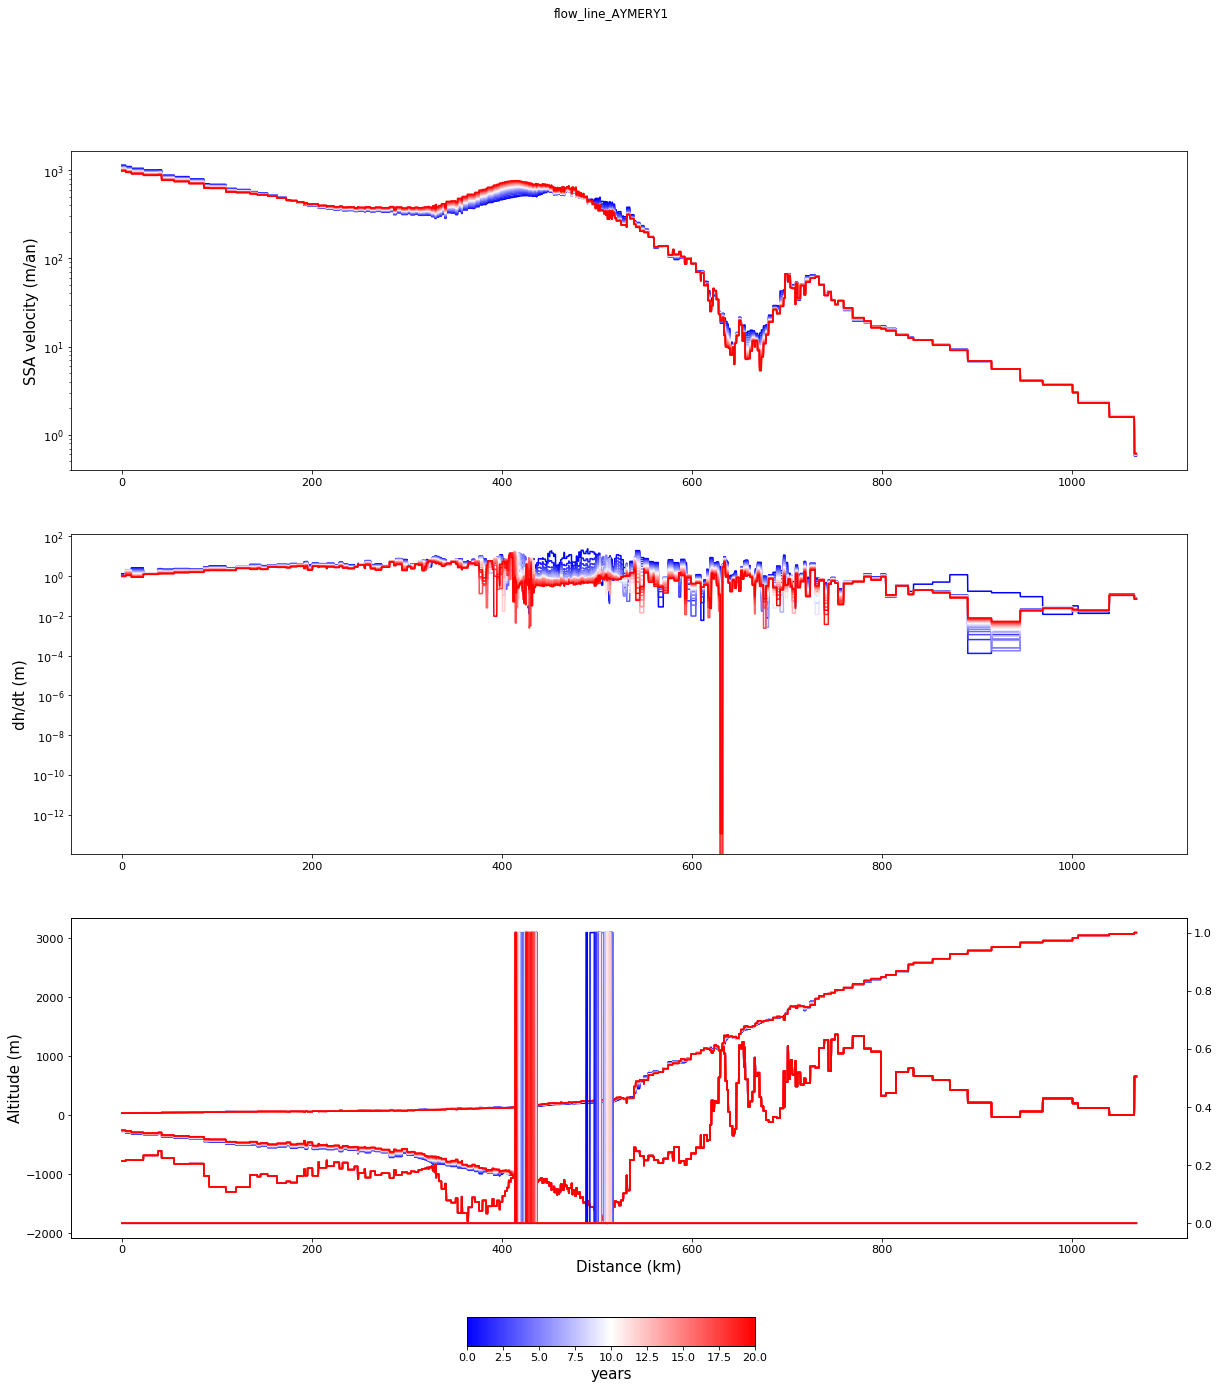

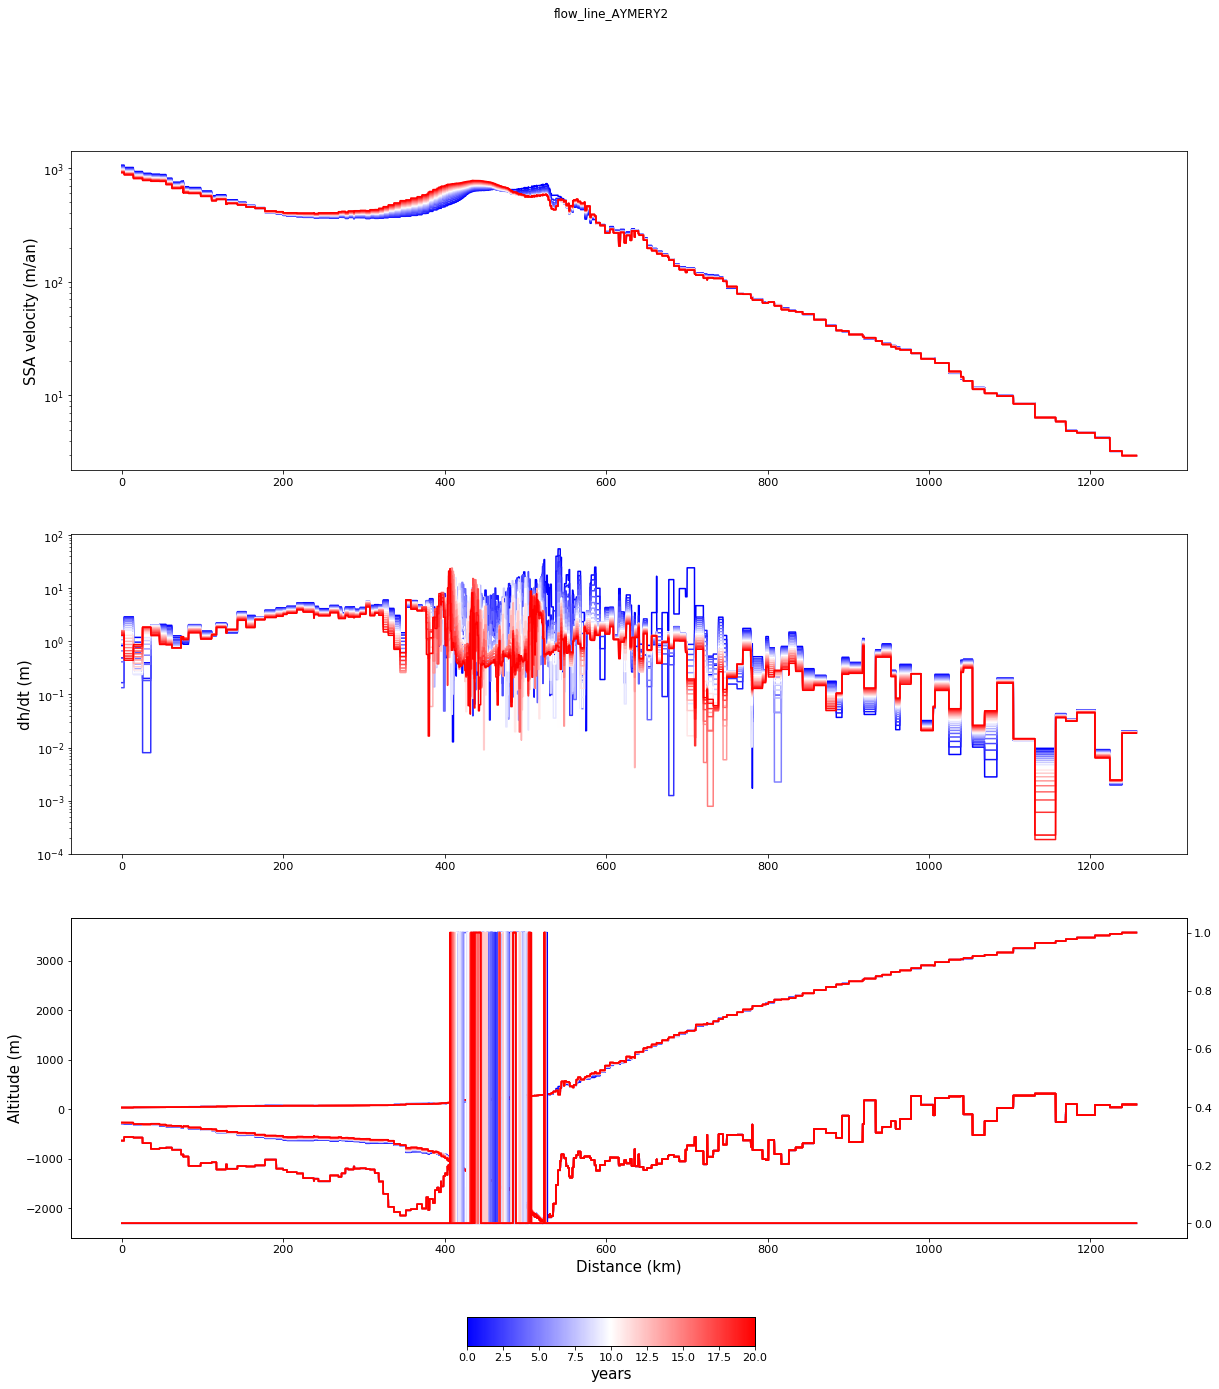

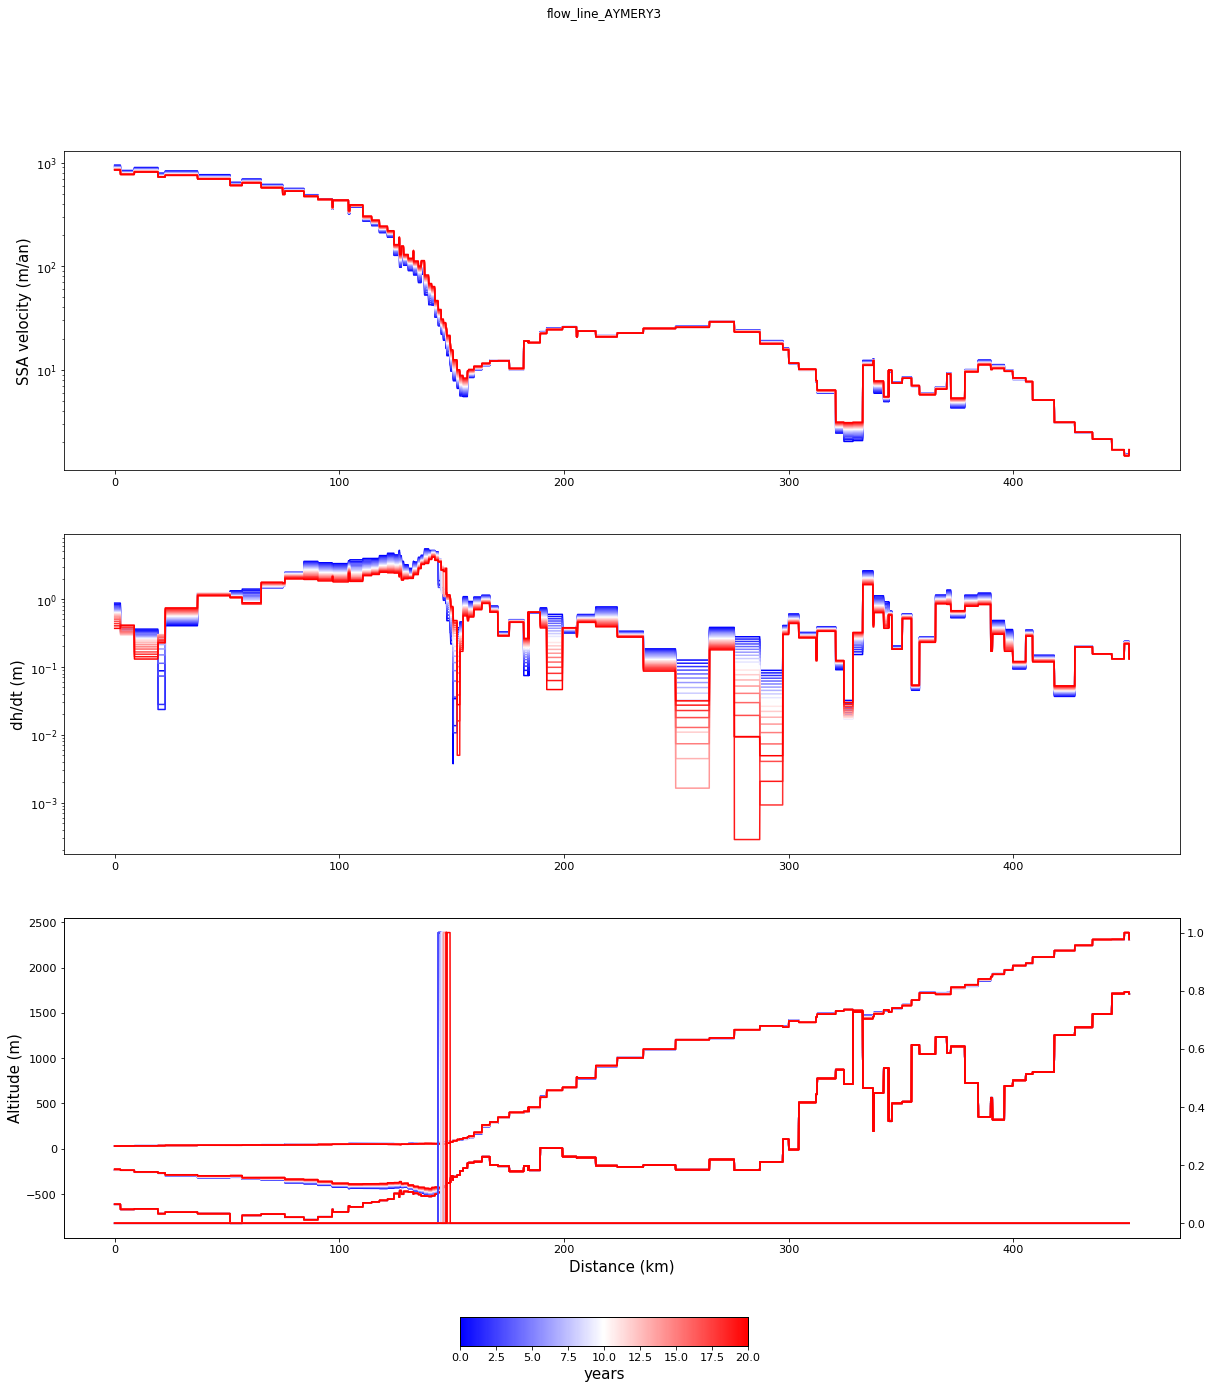

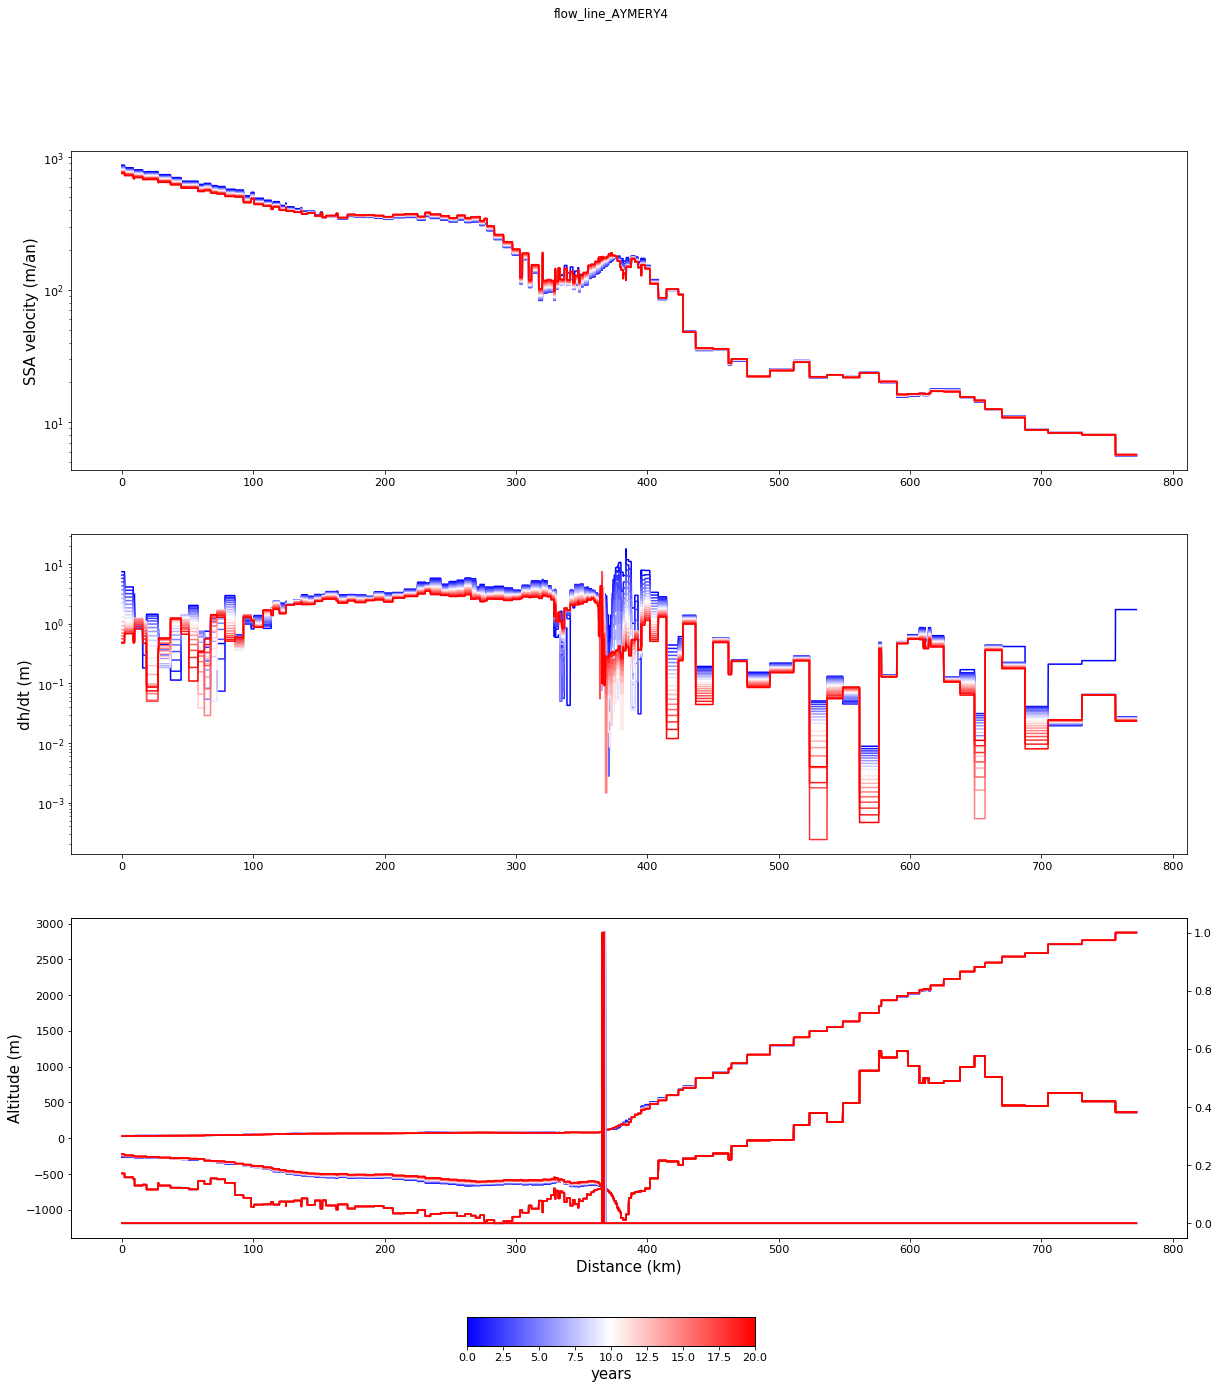

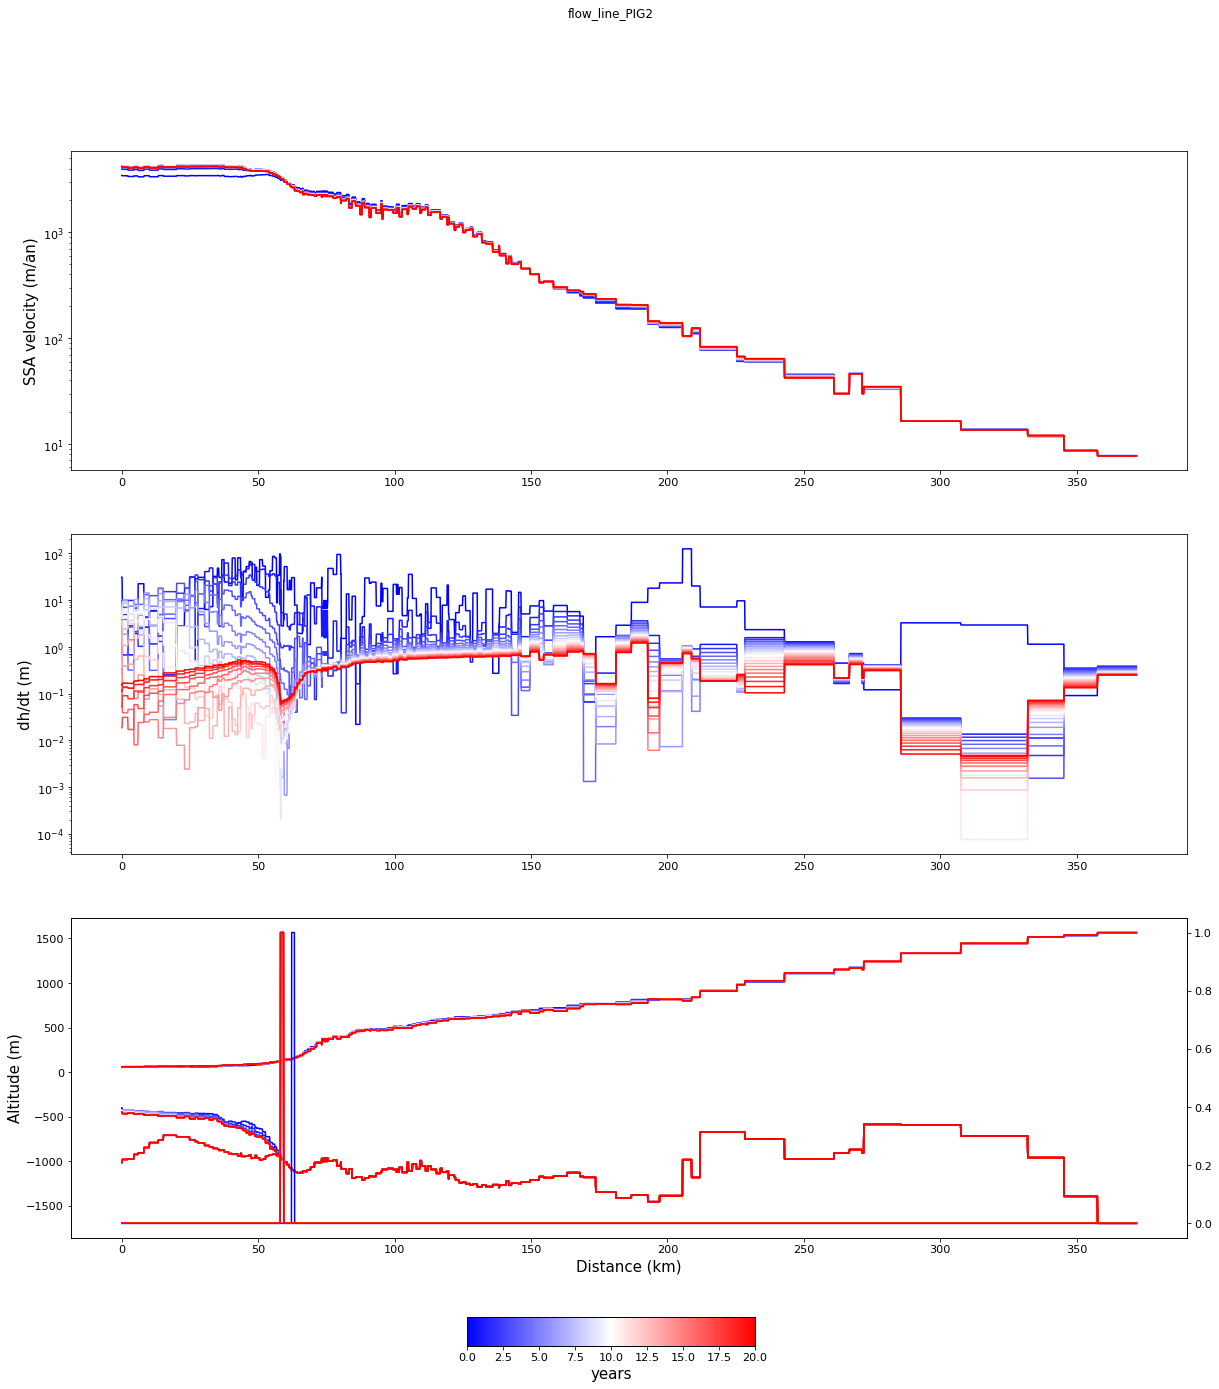

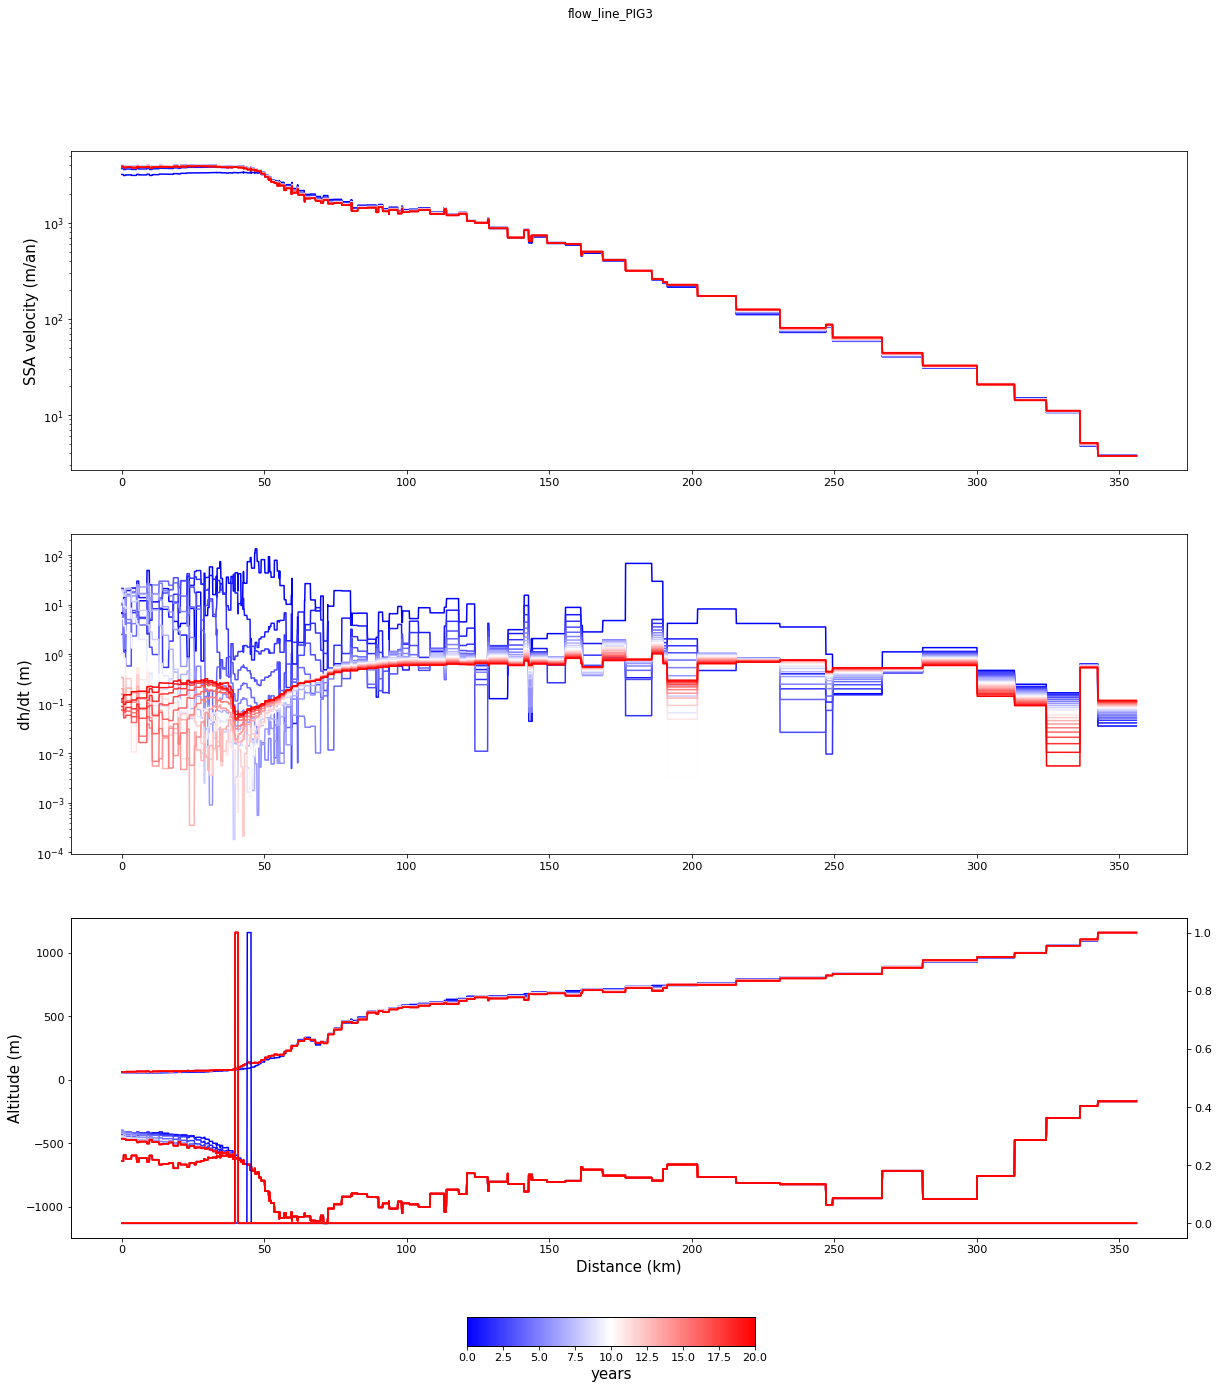

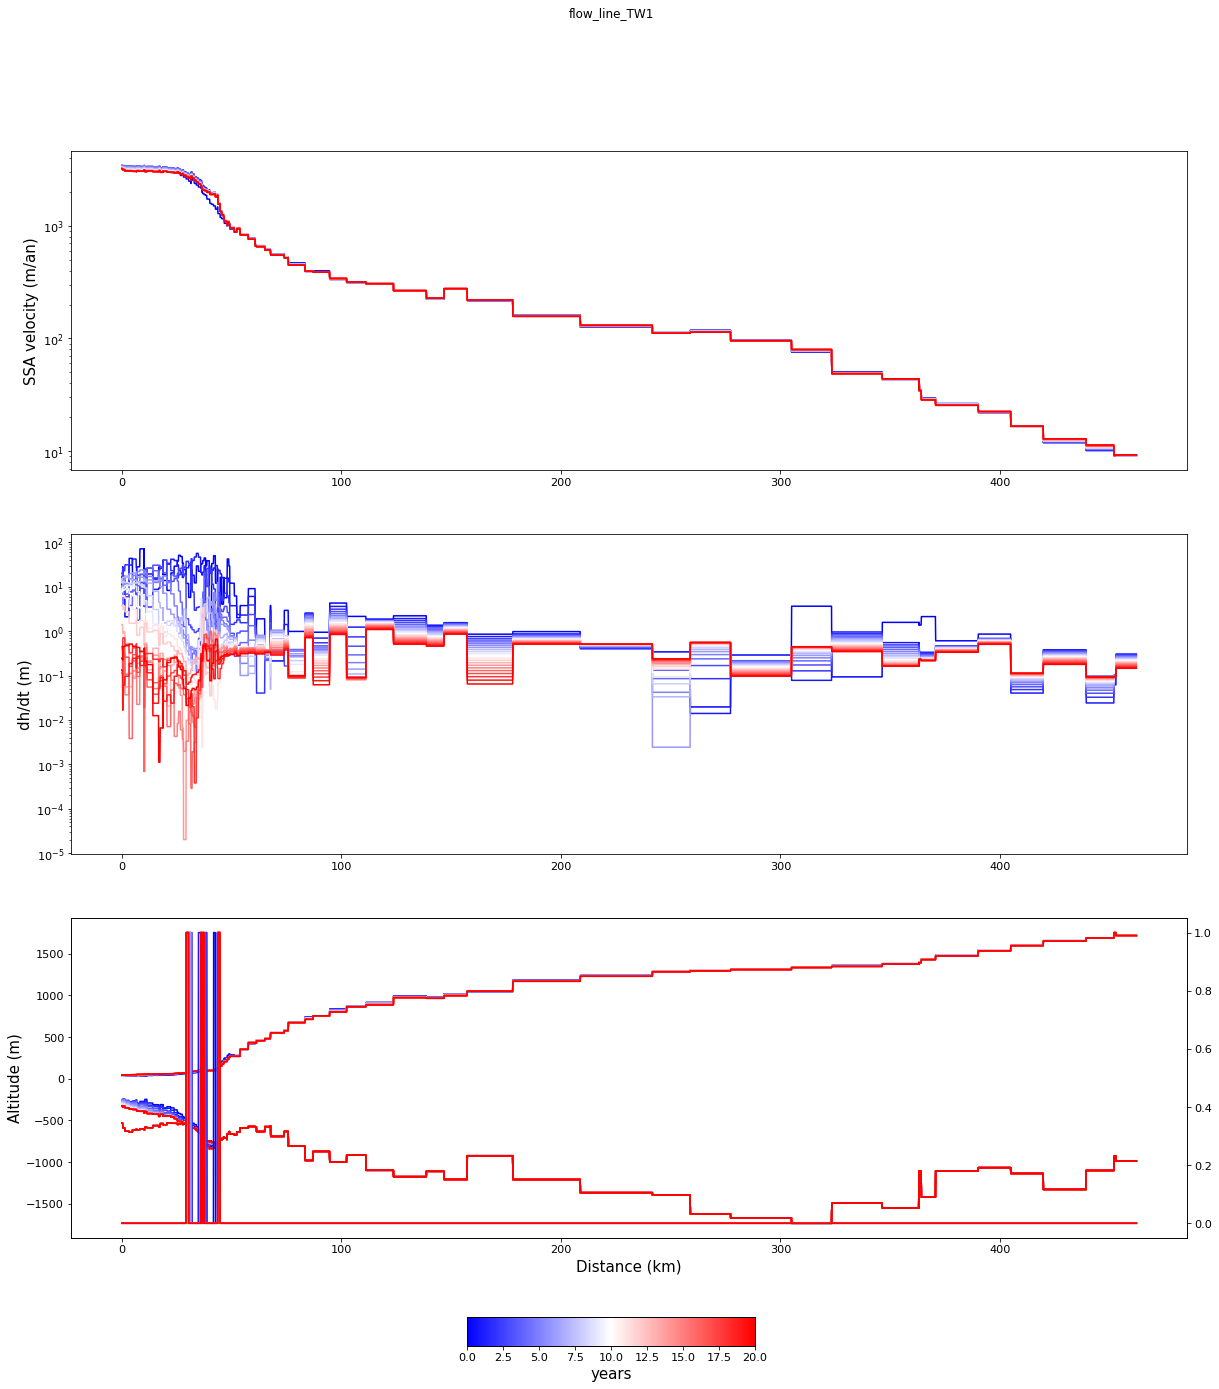

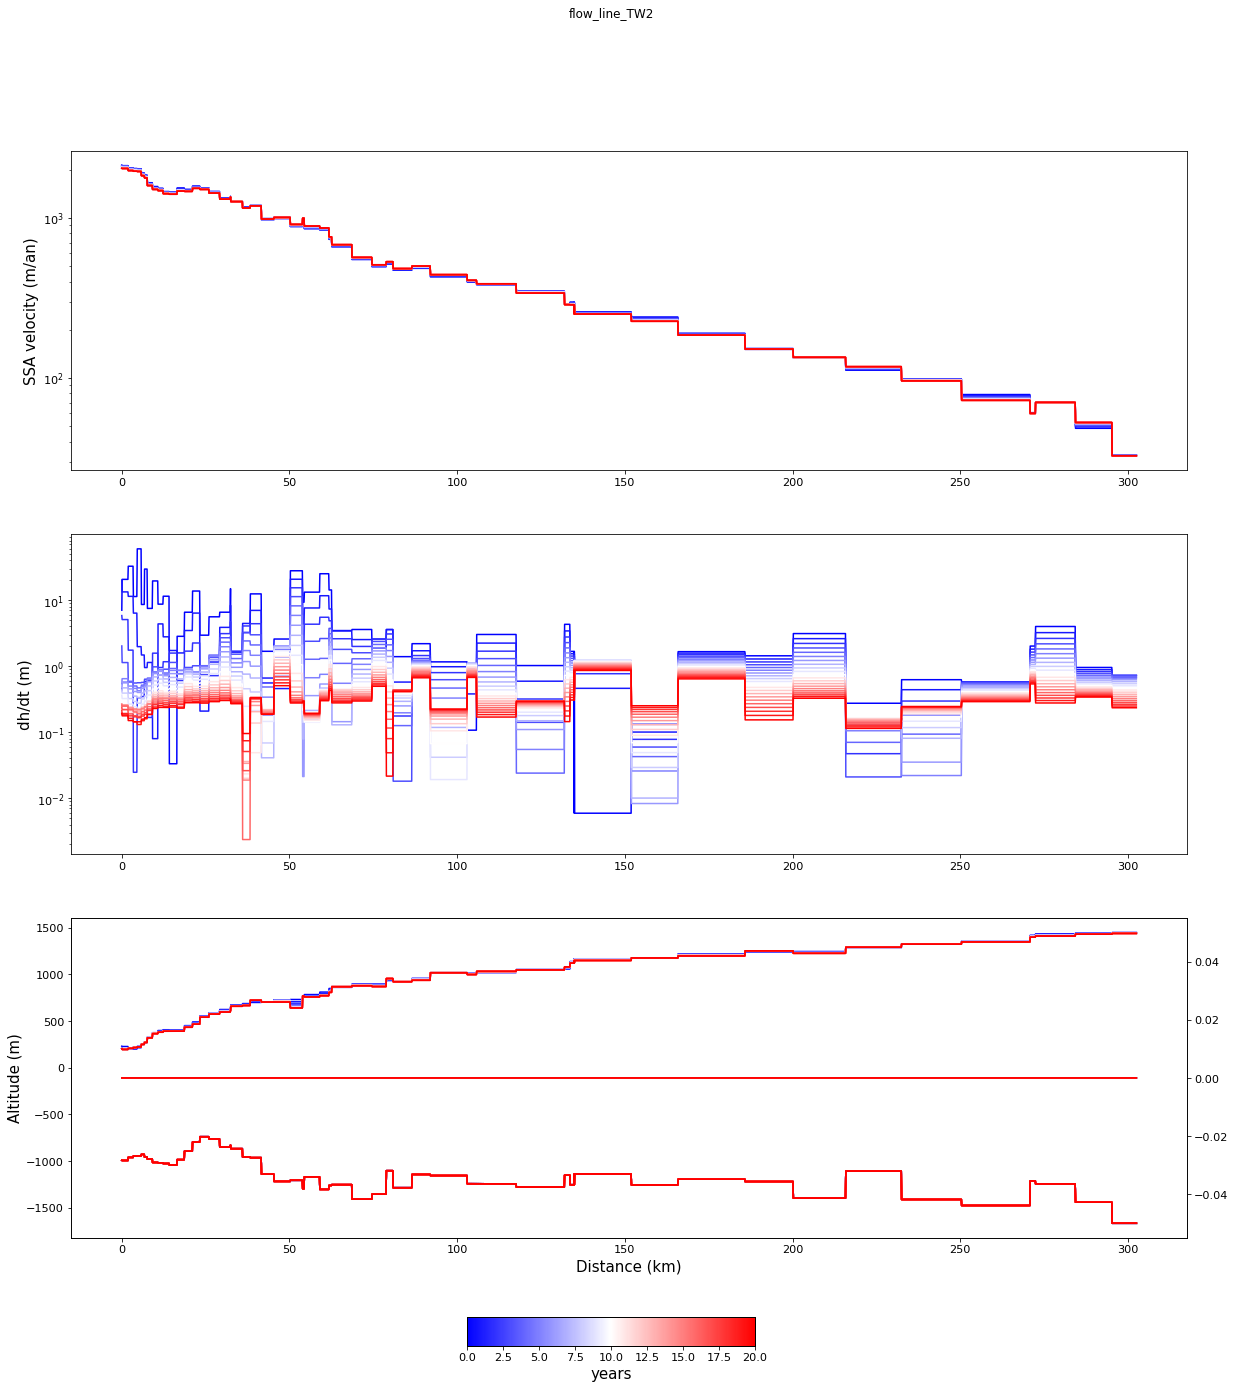

In [4]:
colors = plt.cm.bwr(np.linspace(0,1,len(blocks)))
import matplotlib as mpl

for n in range(0,len(flowlines)):
    xx=flowlines[n][52:-4]
    fig=plt.figure(figsize=[20,20])
   
    ax1=plt.subplot(3,1,1)
    ax2=plt.subplot(3,1,2)
    ax3=plt.subplot(3,1,3)
    ax4 = ax3.twinx()
    for n in range(0,len(blocks)):
        ax1.semilogy(globals()[xx]['dist'],globals()[xx]['ssavelocity_mag'][n,],color=colors[n])
        ax1.set_ylabel('SSA velocity (m/an)')        
        
        ax2.semilogy(globals()[xx]['dist'],abs(globals()[xx]['dhdt'][n,]),color=colors[n])
        ax2.set_ylabel('dh/dt (m)')        

        ax4.plot(globals()[xx]['dist'],abs(globals()[xx]['groundedmask'][n,])<0.1,color=colors[n])
        im=ax3.plot(globals()[xx]['dist'],globals()[xx]['zs'][n,],color=colors[n])
        ax3.plot(globals()[xx]['dist'],globals()[xx]['bedrock'][n,],color=colors[n])
        ax3.plot(globals()[xx]['dist'],globals()[xx]['zb'][n,],color=colors[n],label=str(n))
        ax3.set_xlabel('Distance (km)')
        ax3.set_ylabel('Altitude (m)')
#         ax3.legend()

        ax5=fig.add_subplot(position=[0.4, 0.05, 0.2, 0.02])

        cmap = mpl.cm.bwr
        norm = mpl.colors.Normalize(vmin=0, vmax=len(blocks)-1)

        cb1 = mpl.colorbar.ColorbarBase(ax5, cmap=cmap,
                                        norm=norm,
                                        orientation='horizontal')
        cb1.set_label('years')
        
    fig.suptitle(str(xx))
    

